In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from PIL import Image, ImageFile, UnidentifiedImageError
import scipy
import logging

ImageFile.LOAD_TRUNCATED_IMAGES = True

2024-06-02 14:06:06.096294: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Custom Data Generator to handle corrupted images
class SafeImageDataGenerator(ImageDataGenerator):
    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=self.dtype)
        batch_y = np.zeros((len(index_array), self.num_classes), dtype=self.dtype)
        valid_samples = 0

        for i, j in enumerate(index_array):
            fname = self.filepaths[j]
            try:
                img = self.load_img(fname, color_mode=self.color_mode,
                                    target_size=self.target_size,
                                    interpolation=self.interpolation)
                x = self.img_to_array(img)
                x = self.standardize(x)
                batch_x[valid_samples] = x
                batch_y[valid_samples, self.classes[j]] = 1.
                valid_samples += 1
            except (OSError, ValueError, Image.UnidentifiedImageError) as e:
                logger.warning(f"Skipping corrupted image: {fname}, Error: {e}")

        return batch_x[:valid_samples], batch_y[:valid_samples]

In [3]:
# Define paths
train_dir = '/Users/macbookpro/Documents/capstone_project/Penyakit Kulit/Train'
val_dir = '/Users/macbookpro/Documents/capstone_project/Penyakit Kulit/Validation'
test_dir = '/Users/macbookpro/Documents/capstone_project/Penyakit Kulit/Test'
# clean_dataset(train_dir)
# clean_dataset(val_dir)
# clean_dataset(test_dir)
# Data augmentation and preprocessing
train_datagen = SafeImageDataGenerator(rescale=1./255)
val_datagen = SafeImageDataGenerator(rescale=1./255)
test_datagen = SafeImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    shuffle = True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='categorical',
    shuffle = True
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (180, 180),
    batch_size= 32,
    class_mode = 'categorical',
    shuffle = True
)

Found 10468 images belonging to 16 classes.
Found 1464 images belonging to 16 classes.
Found 748 images belonging to 16 classes.


In [4]:
vgg_base = VGG19(weights = 'imagenet',  include_top = False, input_shape = (180, 180, 3))

In [ ]:
for layer in vgg_base.layers:
    layer.trainable = False

In [5]:
input_layer = Input(shape=(180,180, 3))
vgg_output = vgg_base(input_layer)
vgg_output = Flatten()(vgg_output)
dense_layer_1 = Dense(200, activation='relu')(vgg_output)
dense_layer_2 = Dense(170, activation='relu')(dense_layer_1)
output_layer = Dense(16, activation='softmax')(dense_layer_2)
new_model = Model(inputs = input_layer, outputs = output_layer)


In [12]:
new_model.compile(
    optimizer = Adam(learning_rate = 0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# Callbacks
mcp_save = ModelCheckpoint('skin_disease.h5', save_best_only=True, monitor='val_accuracy')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1,)

In [16]:
new_model = load_model('skin_disease.h5')
history = new_model.fit(
    train_generator,
    epochs = 10,
    validation_data = val_generator,
    callbacks = [mcp_save, reduce_lr]
)

Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.4679 - accuracy: 0.8915

/Users/macbookpro/anaconda3/envs/capstone_project/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 855s 8s/step - loss: 0.4679 - accuracy: 0.8915 - val_loss: 0.3033 - val_accuracy: 0.9253 - lr: 5.0000e-05
Epoch 2/10
104/104 [==============================] - 854s 8s/step - loss: 0.4546 - accuracy: 0.8969 - val_loss: 0.2996 - val_accuracy: 0.9207 - lr: 5.0000e-05
Epoch 3/10
104/104 [==============================] - 854s 8s/step - loss: 0.4451 - accuracy: 0.8957 - val_loss: 0.2938 - val_accuracy: 0.9332 - lr: 5.0000e-05
Epoch 4/10
104/104 [==============================] - 851s 8s/step - loss: 0.4341 - accuracy: 0.8972 - val_loss: 0.2823 - val_accuracy: 0.9275 - lr: 5.0000e-05
Epoch 5/10
104/104 [==============================] - ETA: 0s - loss: 0.4235 - accuracy: 0.8984
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
104/104 [==============================] - 857s 8s/step - loss: 0.4235 - accuracy: 0.8984 - val_loss: 0.2777 - val_accuracy: 0.9320 - lr: 5.0000e-05
Epoch 6/10
104/104 [==============================

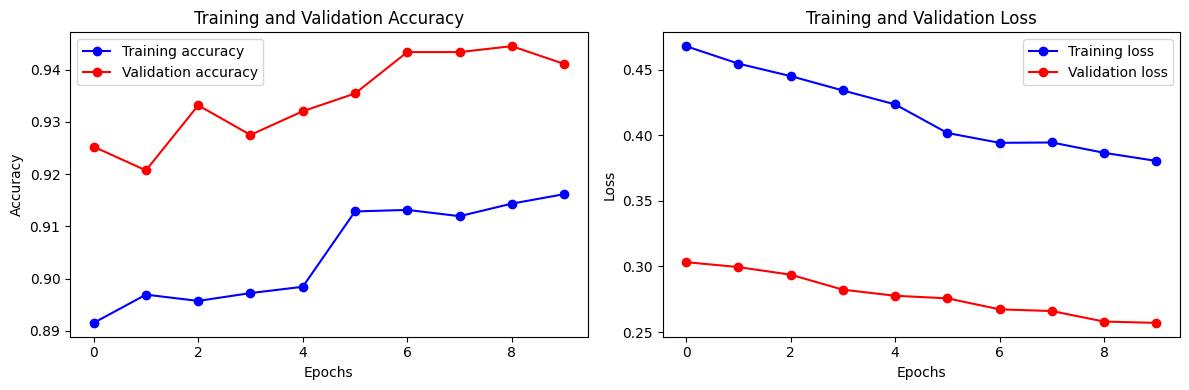

In [17]:
import matplotlib.pyplot as plt

# Extracting the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Number of epochs
epochs = range(len(acc))

# Plotting training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
loss, accuracy = new_model.evaluate(test_generator)
print(f'Test Loss : {loss}')
print(f'Test Accuracy: {accuracy}')

13/24 [===============>..............] - ETA: 1:18 - loss: 0.3327 - accuracy: 0.9255

In [ ]:
new_model.save('Vgg19ModelTuning.h5')